# TO DO
- write some example of queries
- ask the queries to the network

## DONE
- teainare sul 2022
- vere i risultati sul test
- prendi la modello che ha imparato, fai la variable elimination e vedi come si comporta
- cambiare da accuracy ad una metrica basata sulla distanza (infatti l'errore è meno grave più il risultato è vicino al risultato corretto)



# Predicting wins through players advanced statistics
<br>
    <center><img src="https://media1.giphy.com/media/XIhWoPBXHgVmU/giphy.gif?cid=ecf05e47zplee7bvey2l2qj0tn5bo4utclw4s7w8ovsgsk9v&ep=v1_gifs_search&rid=giphy.gif&ct=g"></center>
<br>

### Project carried out by [Giacomo Piergentili](https://github.com/GiacomoPiergentili) and [Francesco Cavaleri](https://github.com/CacioCavalloIsNotReal) for the Fundamentals of AI and KR course - module 3


2023_nba_player_stats.csv was downloaded [here](https://www.kaggle.com/datasets/amirhosseinmirzaie/nba-players-stats2023-season/data) and the other dataset was downloaded [here](https://www.nbastuffer.com/2022-2023-nba-player-stats/)

In [400]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import seaborn as sns
import networkx as nx
import numpy as np
from pgmpy.models import BayesianNetwork
from feature_engine.discretisation import EqualWidthDiscretiser
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import TreeSearch


# settings and vars
seed = 69
bins = 4
useful_vars=['NAME', 'AGE', 'APG', 'AST_RATIO', 'eFG%', \
             'FTA_RATE', 'DRtg', 'DREBPG', 'Min', 'TO%', \
                'OREBPG', 'ORtg', 'USG%', 'WIN%']

GP_threshold = 61

## Define some frequent used functions

In [401]:
def normalizer(name):
    # Perform case folding
    return name['NAME']\
        .replace(r"['\-. _\"]",'', regex=True)\
        .str.lower()

def discretizer(dataset, n_bins=4):
    widthDiscretiser=EqualWidthDiscretiser(bins=n_bins)
    widthDiscretiser.fit(dataset)
    return widthDiscretiser.transform(dataset)

def model_checker(custom_model):
    if not custom_model.check_model():
        print('The model has errors.')
    else:
        print('The model has no errors.')

def df_checker(dataset):
    if len(dataset.count().unique()) == 1:
        print('The dataset does not contains missing values')
        return 0
    else:
        print('The dataset does contains missing values')
        return 1
    # if dataset.isna().sum().sum() == 0:
    #     print('the dataset does not contains Nan')

def df_finalizer(dataset):
    dataset['FTA_RATE'] = dataset['FTA'] / dataset['FGA']
    dataset['AST_RATIO'] = 100 * dataset['FTA'] / \
            (dataset['AST'] + dataset['FGA']+ 0.44 * dataset['FTA'] + dataset['TOV'])
    dataset['WIN%'] = dataset['W'] / dataset['GP']
    dataset['OREBPG'] = dataset['OREB'] / dataset['GP']
    dataset['DREBPG'] = dataset['DREB'] / dataset['GP']
    dataset = dataset[useful_vars]
    dataset.reset_index(inplace=True, drop=True)
    return dataset


## Prepare the first dataset
There were some problems in this dataset given to the fact that some players changed teams during the season and there were multiple rows of statistics for each team the player played instead of grouping them in just one row. After solving the problem we just selected the statistics that we needed.

In [402]:
# nuova funztione scritta da 0. la cosa è molto complicata
df1 = pd.read_csv('datasets/train/202122_NBA_stats.csv')

df1.rename(columns={'FULL NAME':'NAME',
                    'TOPG':'TPG',
                    'ORTG':'ORtg',
                    'DRTG':'DRtg'},
                inplace=True)

# stats we want to collect for each player
stats = ['USG%', 'TO%', 'eFG%', 'APG', 'TPG', 'ORtg', 'DRtg']

if df_checker(df1):
    df1.dropna(axis=0, inplace=True, ignore_index=True)

df1['NAME'] = normalizer(df1)
print(len(np.unique(df1['NAME'])))
print(df1.columns.values)

def weighted_average(x):
    x_new = {}
    
    # Game Played is given by the sum of the played games on different teams
    x_new['GP'] = x['GP'].sum()
    # Usage Percentage is the percentage of team plays used by a player while he was on the floor
    # so it is weighted by Minutes Played per Game
    x_new['USG%'] = np.average(x['USG%'], weights = x['MPG'])
    # Turn Over percentage is weighted by the number of possessions wich is given by USG%
    x_new['TO%'] = np.average(x['TO%'], weights = x['USG%'])
    # Effective Field Goal Percentage takes into account the value of three-pointers
    # It's already weighted by the number of attempts
    x_new['eFG%'] = np.average(x['eFG%'], weights = x['2PA'] + x['3PA'])
    # weighted average of the 'APG' (Assists Per Game) statistic for a player across different teams
    x_new['APG'] = np.average(x['APG'], weights = x['GP'])
    # Turnovers Per Game represents the average number of turnovers a player makes per game
    x_new['TPG'] = np.average(x['TPG'], weights = x['GP'])
    # Offensive Rating It reflects the player's overall offensive impact, with more
    # weight given to teams where the player had a larger presence in terms of games played
    x_new['ORtg'] = np.average(x['ORtg'], weights = x['GP'])
    # Defensive Rating weighted by the number of games played
    x_new['DRtg'] = np.average(x['DRtg'], weights = x['GP'])

    return pd.Series(x_new)

df1 = df1.groupby('NAME').apply(weighted_average).reset_index()

# NB. 'aaron holiday' changed his team

The dataset does contains missing values
571
['NAME' 'TEAM' 'POS' 'AGE' 'GP' 'MPG' 'MIN%' 'USG%' 'TO%' 'FTA' 'FT%'
 '2PA' '2P%' '3PA' '3P%' 'eFG%' 'TS%' 'PPG' 'RPG' 'TRB%' 'APG' 'AST%'
 'SPG' 'BPG' 'TPG' 'VI' 'ORtg' 'DRtg']


In [403]:
df1

,NAME,GP,USG%,TO%,eFG%,APG,TPG,ORtg,DRtg
0,aarongordon,75.0,19.700000,12.500000,0.573000,2.50000,1.770000,115.60000,109.900000
1,aaronholiday,63.0,18.952923,15.445119,0.504491,2.42381,1.047778,107.55873,106.555556
2,aaronnesmith,52.0,17.200000,13.800000,0.481000,0.40000,0.600000,95.50000,97.500000
3,aaronwiggins,50.0,15.300000,12.600000,0.525000,1.40000,1.080000,107.90000,109.600000
4,abdelnader,14.0,14.900000,21.800000,0.400000,0.50000,0.790000,78.80000,94.900000
...,...,...,...,...,...,...,...,...,...
566,zachlavine,67.0,28.800000,11.200000,0.554000,4.50000,2.550000,115.10000,112.800000
567,zaviersimpson,4.0,15.900000,15.600000,0.375000,7.50000,2.500000,91.40000,108.200000
568,zekennaji,41.0,14.900000,9.700000,0.616000,0.40000,0.560000,124.00000,104.000000
569,ziairewilliams,62.0,14.900000,8.400000,0.540000,1.00000,0.660000,112.90000,107.100000


In [404]:
df1[df1['NAME']=='aaronholiday']

,NAME,GP,USG%,TO%,eFG%,APG,TPG,ORtg,DRtg
1,aaronholiday,63.0,18.952923,15.445119,0.504491,2.42381,1.047778,107.55873,106.555556


Read the second dataset. No problems here so we proceed to selecting just the statistics that we need.

In [405]:
df2 = pd.read_csv('datasets/train/2122_Stats_NBAcom.csv')

if df_checker(df2):
    df2.dropna(axis=0, inplace=True, ignore_index=True)


df2.rename(columns={'PLAYER':'NAME',
                    'MIN':'Min'},
                inplace=True)

df2 = df2[['NAME', 'AGE', 'W', 'Min', 'FGA', 'FTA', 'AST', 'TOV', 'OREB', 'DREB']].copy()

df2['NAME'] = normalizer(df2)

print(len(df2['NAME']))
df2.head()

The dataset does not contains missing values
605


,NAME,AGE,W,Min,FGA,FTA,AST,TOV,OREB,DREB
0,bogdanbogdanovic,29,33,1848.5,794,115,194,70,29,221
1,cameronoliver,25,1,43.3,15,3,3,0,2,4
2,catbarber,27,0,12.8,4,4,3,1,1,2
3,chaundeebrownjr,23,1,103.7,32,6,4,1,1,15
4,clintcapela,28,40,2041.5,604,169,92,44,279,598


Merged the datasets to create one with almost all the statistics that we needed.

In [406]:
df = pd.merge(df2, df1, on='NAME')
df.head()

,NAME,AGE,W,Min,FGA,FTA,AST,TOV,OREB,DREB,GP,USG%,TO%,eFG%,APG,TPG,ORtg,DRtg
0,bogdanbogdanovic,29,33,1848.5,794,115,194,70,29,221,63.0,21.600000,7.700000,0.537000,3.10,1.11,114.30,110.30
1,cameronoliver,25,1,43.3,15,3,3,0,2,4,2.0,16.500000,0.000000,0.700000,1.50,0.00,149.90,107.00
2,catbarber,27,0,12.8,4,4,3,1,1,2,3.0,23.100000,14.800000,0.000000,1.00,0.33,37.80,110.90
3,chaundeebrownjr,23,1,103.7,32,6,4,1,1,15,5.0,15.096316,6.690705,0.406281,0.78,0.20,81.54,113.42
4,clintcapela,28,40,2041.5,604,169,92,44,279,598,74.0,15.500000,6.100000,0.613000,1.20,0.59,134.00,104.90


In [407]:
df.shape

(570, 18)

Computed the last needed statistics and then created a new dataset to store only the ones that we really needed.

In [408]:
df = df[df['GP'] >= GP_threshold]
df_final = df_finalizer(df)
df_final.head()

,NAME,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
0,bogdanbogdanovic,29,3.1,10.373444,0.537,0.144836,110.3,3.507937,1848.5,7.7,0.460317,114.3,21.6,0.523810
1,clintcapela,28,1.2,20.752493,0.613,0.279801,104.9,8.081081,2041.5,6.1,3.770270,134.0,15.5,0.540541
2,danilogallinari,33,1.5,19.387552,0.528,0.261307,112.1,4.136364,1672.1,5.4,0.530303,119.8,18.4,0.530303
3,delonwright,30,2.4,11.893076,0.535,0.234201,112.3,2.207792,1452.5,13.2,0.649351,126.2,10.3,0.545455
4,kevinhuerter,23,2.7,4.828765,0.559,0.068421,110.1,3.000000,2188.5,10.4,0.432432,111.6,17.5,0.540541


In [409]:
df_final.shape

(209, 14)

FINO A QUA ABBIAMO IL DATASET DI TRAIN CHE FUNZIONA

Discretizing continuos variables

Text(0, 0.5, 'Numbers')

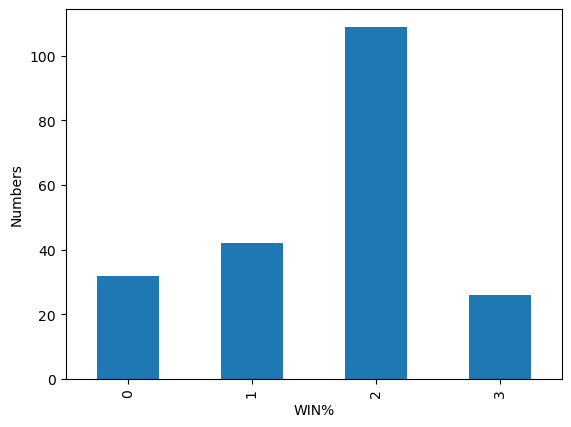

In [410]:

discretized_df= discretizer(df_final, n_bins=bins)

discretized_df.groupby('WIN%')['WIN%'].count().plot.bar()
plt.ylabel('Numbers')

In [411]:
discretized_df.describe()

,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
count,209.000000,209.00000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,1.071770,0.45933,0.578947,0.913876,0.468900,1.856459,0.550239,1.655502,1.244019,0.392344,0.956938,0.956938,1.617225
std,0.882314,0.74648,0.631495,0.673859,0.628061,0.764896,0.764986,0.963757,0.873089,0.733235,0.681530,0.816337,0.891676
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,1.000000,0.00000,1.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000,2.000000
75%,2.000000,1.00000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000
max,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


This is the final dataset we are going to use

In [412]:
discretized_df.head()

,NAME,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
0,bogdanbogdanovic,2,1,0,1,0,2,0,2,0,0,1,1,2
1,clintcapela,1,0,1,2,1,2,2,2,0,3,2,0,2
2,danilogallinari,2,0,1,1,1,3,1,1,0,0,1,1,2
3,delonwright,2,0,0,1,0,3,0,1,2,0,2,0,2
4,kevinhuerter,0,0,0,1,0,2,0,2,1,0,1,1,2


array([[<Axes: title={'center': 'AGE'}>, <Axes: title={'center': 'APG'}>,
        <Axes: title={'center': 'AST_RATIO'}>,
        <Axes: title={'center': 'eFG%'}>],
       [<Axes: title={'center': 'FTA_RATE'}>,
        <Axes: title={'center': 'DRtg'}>,
        <Axes: title={'center': 'DREBPG'}>,
        <Axes: title={'center': 'Min'}>],
       [<Axes: title={'center': 'TO%'}>,
        <Axes: title={'center': 'OREBPG'}>,
        <Axes: title={'center': 'ORtg'}>,
        <Axes: title={'center': 'USG%'}>],
       [<Axes: title={'center': 'WIN%'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

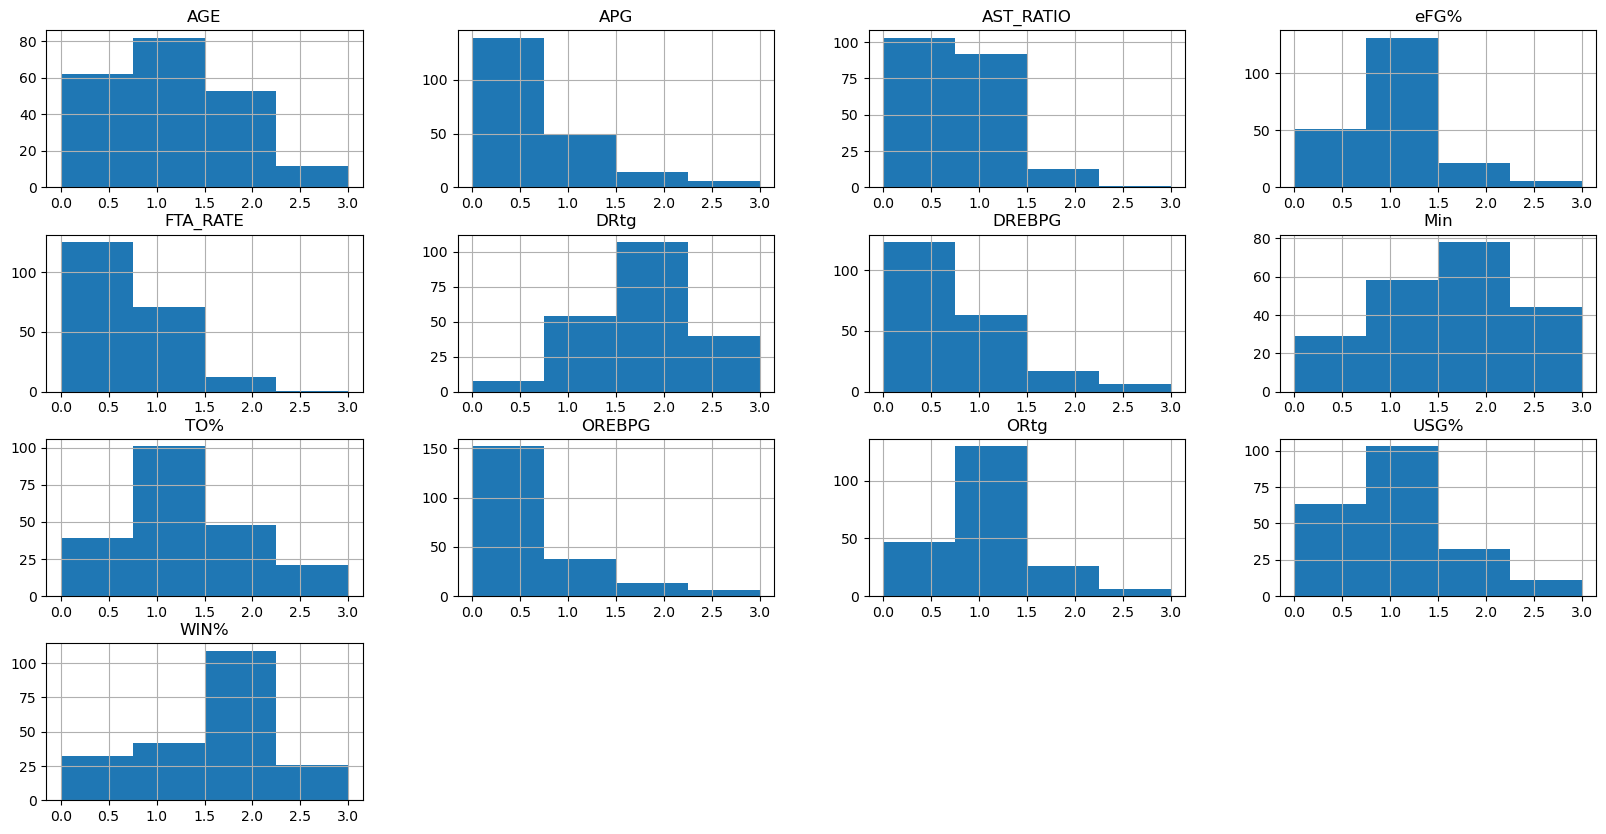

In [413]:
discretized_df.hist(bins=bins, figsize=(20,10))

Text(0.5, 1.0, 'Model')

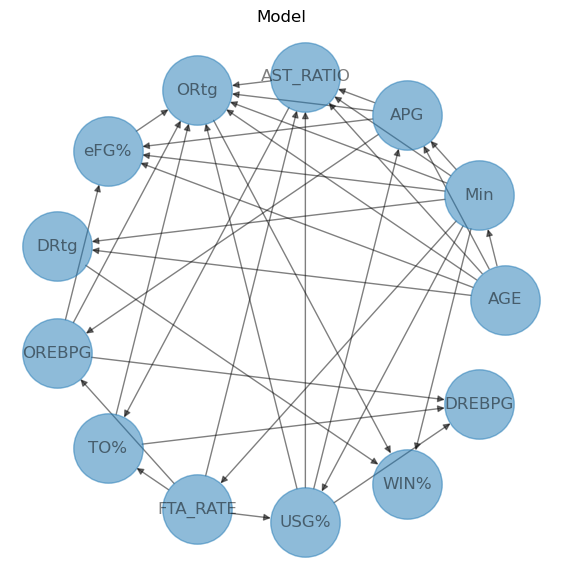

In [414]:
custom_model = BayesianNetwork([('AGE', 'Min'), ('AGE', 'APG'),
                                ('AGE', 'AST_RATIO'), ('AGE', 'ORtg'),
                                ('AGE', 'eFG%'), ('AGE', 'DRtg'),
                                ('APG', 'AST_RATIO'), ('APG', 'OREBPG'),
                                ('APG', 'ORtg'), ('APG', 'eFG%'),
                                ('AST_RATIO', 'ORtg'), ('AST_RATIO', 'TO%'),
                                ('eFG%', 'ORtg'),
                                ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'OREBPG'),
                                ('FTA_RATE', 'TO%'), ('FTA_RATE', 'USG%'),
                                ('DRtg', 'WIN%'),
                                ('Min', 'FTA_RATE'), ('Min', 'APG'),
                                ('Min', 'AST_RATIO'), ('Min', 'USG%'),
                                ('Min', 'ORtg'), ('Min', 'eFG%'),
                                ('Min', 'WIN%'), ('Min', 'DRtg'),
                                ('TO%', 'DREBPG'), ('TO%', 'ORtg'),
                                ('OREBPG', 'eFG%'), ('OREBPG', 'ORtg'),
                                ('OREBPG', 'DREBPG'),
                                ('ORtg', 'WIN%'),
                                ('USG%', 'APG'), ('USG%', 'AST_RATIO'),
                                ('USG%', 'DREBPG'), ('USG%', 'ORtg')])
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
nx.draw_circular(custom_model, with_labels=True, node_size=2500, alpha=0.5, ax=ax)
ax.set_title('Model')


In [415]:
custom_model.fit(discretized_df, n_jobs=6)
model_checker(custom_model)

The model has no errors.


In [416]:
#????????
# cpds = custom_model.get_cpds()
# error_telling(cpds)

In [417]:
nb_inference = VariableElimination(custom_model)

In [418]:
campione = 0

result = nb_inference.query(
            variables=['WIN%'],
            evidence=discretized_df
                .drop('WIN%', axis=1)
                .drop('NAME', axis=1)
                .iloc[campione]
                .to_dict(),
            show_progress=False,
        )

print('predicted: ',np.argmax(result.values))
print('truth: ', discretized_df.iloc[campione].to_dict()['WIN%'])

predicted:  2
truth:  2


In [419]:
result.values

array([0.14285714, 0.17857143, 0.53571429, 0.14285714])

In [420]:
train_results={'estimated':[]}
for i in range(df.shape[0]):
    result = nb_inference.query(
            variables=['WIN%'],
            evidence=discretized_df
                .drop('WIN%', axis=1)
                .drop('NAME', axis=1)
                .iloc[i]
                .to_dict(),
            show_progress=False,
        )
    train_results['estimated'].append(np.argmax(result.values))
    

In [421]:
train_mae = mean_absolute_error(discretized_df['WIN%'].values,train_results['estimated'])
print(train_mae)

0.49760765550239233


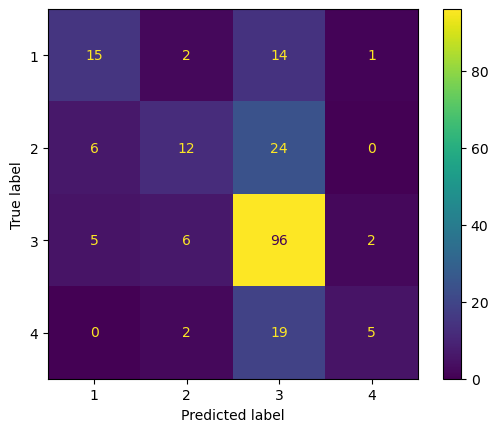

In [422]:
cm = confusion_matrix(discretized_df['WIN%'].values,train_results['estimated'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=range(1,bins+1))
disp.plot()
plt.show()

In [423]:
# The result of this piece of code is a DAG

numeric_df=discretized_df.drop('NAME',axis=1)
hc = HillClimbSearch(numeric_df, use_cache=True)
best_est_model={0:{'estimator':BicScore},
                1:{'estimator':BDeuScore },
                2:{'estimator':K2Score}}

for i in range(3):
       print('\nestimating using the ', best_est_model[i]['estimator'].__name__, 'estimator')
       best_est_model[i]['DAG'] = hc.estimate(
              scoring_method=best_est_model[i]['estimator'](numeric_df),
              epsilon = 1e-8,
              max_indegree = 5 # max number of parents per node
              #tabu_length = 1000 # boh
              #start_dag = custom_model
              #fixed_edges = [('Min', 'WIN%')]
              )
                                          
       print(best_est_model[i]['DAG'].edges())


estimating using the  BicScore estimator


  0%|          | 7/1000000 [00:00<13:11:48, 21.05it/s]


[('APG', 'Min'), ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'OREBPG'), ('OREBPG', 'DREBPG'), ('OREBPG', 'ORtg'), ('ORtg', 'eFG%'), ('USG%', 'APG')]

estimating using the  BDeuScore estimator


  0%|          | 12/1000000 [00:00<5:14:24, 53.01it/s]


[('APG', 'Min'), ('APG', 'TO%'), ('eFG%', 'ORtg'), ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'OREBPG'), ('DRtg', 'WIN%'), ('DREBPG', 'USG%'), ('OREBPG', 'DREBPG'), ('OREBPG', 'eFG%'), ('OREBPG', 'DRtg'), ('ORtg', 'AGE'), ('USG%', 'APG')]

estimating using the  K2Score estimator


  0%|          | 42/1000000 [00:00<2:29:42, 111.33it/s]

[('AGE', 'USG%'), ('AGE', 'Min'), ('APG', 'USG%'), ('APG', 'Min'), ('APG', 'DREBPG'), ('APG', 'OREBPG'), ('APG', 'TO%'), ('APG', 'WIN%'), ('APG', 'eFG%'), ('AST_RATIO', 'DREBPG'), ('AST_RATIO', 'OREBPG'), ('AST_RATIO', 'WIN%'), ('AST_RATIO', 'TO%'), ('AST_RATIO', 'USG%'), ('AST_RATIO', 'DRtg'), ('AST_RATIO', 'Min'), ('AST_RATIO', 'eFG%'), ('eFG%', 'ORtg'), ('eFG%', 'WIN%'), ('eFG%', 'DRtg'), ('FTA_RATE', 'AST_RATIO'), ('FTA_RATE', 'OREBPG'), ('FTA_RATE', 'DREBPG'), ('FTA_RATE', 'TO%'), ('FTA_RATE', 'USG%'), ('FTA_RATE', 'DRtg'), ('FTA_RATE', 'Min'), ('FTA_RATE', 'eFG%'), ('Min', 'TO%'), ('Min', 'DRtg'), ('TO%', 'OREBPG'), ('OREBPG', 'DREBPG'), ('OREBPG', 'eFG%'), ('OREBPG', 'DRtg'), ('OREBPG', 'WIN%'), ('ORtg', 'DREBPG'), ('ORtg', 'WIN%'), ('USG%', 'OREBPG'), ('USG%', 'TO%'), ('USG%', 'Min'), ('USG%', 'eFG%')]


The model has no errors.
The model has no errors.
The model has no errors.


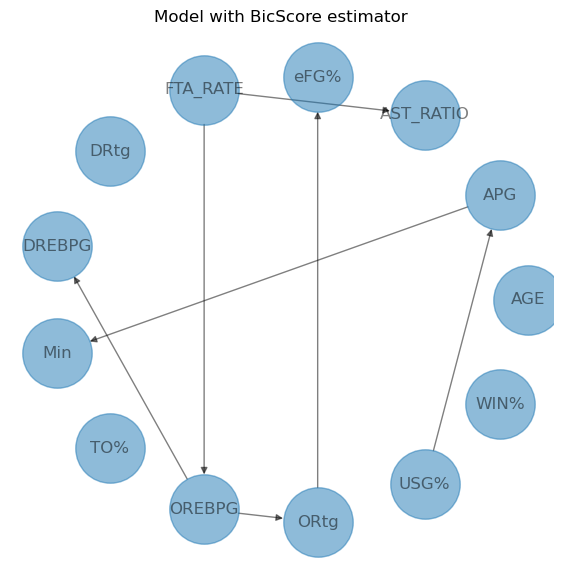

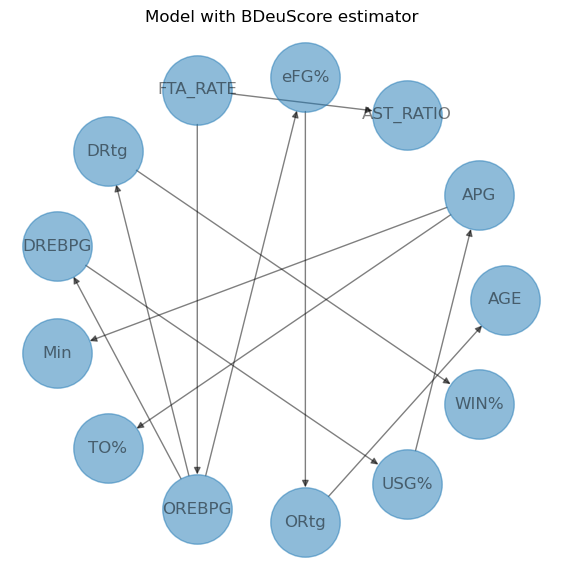

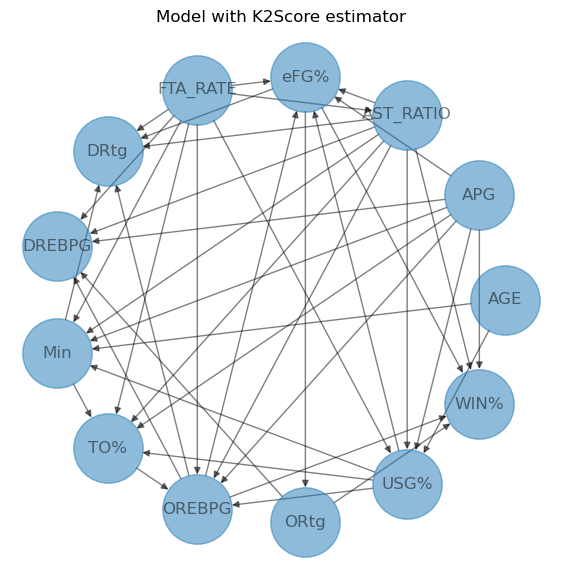

In [424]:
for i in range(3):
    # Here i create the model
    best_est_model[i]['model']=BayesianNetwork(best_est_model[i]['DAG'])
    # Fit the i-th model
    best_est_model[i]['model'].fit(discretized_df, n_jobs=6)
    model_checker(best_est_model[i]['model'])
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    nx.draw_circular(best_est_model[i]['model'],
                     with_labels=True,
                     node_size=2500,
                     alpha=0.5,
                     ax=ax)
    ax.set_title('Model with ' + best_est_model[i]['estimator'].__name__ + ' estimator')

- The first tree (the one generated with BicScore estimator) have a big problem: it is not able to capture all interesting the dependencies in our dataset, for that reason many nodes are independent.
- The second tree (the one generated with BDeuScore estimator) is in a good shape to perform some tests: it capture a certain amounts on dependencies even with our tiny dataset.
- The third tree (the one generated with K2Score estimator) has captured too many dependencies with our dataset: it is impossible to fed this network with our amount of data.
For that reason we performed the Chow_Liu algorithm on the last tree to see, with the smaller tree how it perform. During testing we had seen that the new obtained network has behaved better on test data

We can try to learn the structure of the network using the Chow-Liu algorithm as descripter [here](https://pgmpy.org/examples/Structure%20Learning%20with%20Chow-Liu.html)

first we generate sample data from our tree Bayesian network

In [425]:
# sample data from BN
inference = BayesianModelSampling(
    best_est_model[2]['model']
    )
df_data = inference.forward_sample(
    size=10000,
    seed=seed,
    show_progress=True,
    n_jobs=6)

#print(df_data)

Generating for node: WIN%: 100%|██████████| 13/13 [00:00<00:00, 112.39it/s]  
/opt/homebrew/Caskroom/miniconda/base/envs/faikr3-env/lib/python3.11/site-packages/pgmpy/sampling/base.py:582: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


then we apply the Chow-Liu algorithm to learn the tree graph from sample data

Building tree:   0%|          | 0/78.0 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/faikr3-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/Caskroom/miniconda/base/envs/faikr3-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/Caskroom/miniconda/base/envs/faikr3-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/Caskroom/miniconda/base/envs/faikr3-env/lib/python3.11/site-packages/s

The model has no errors.


Text(0.5, 1.0, '3rd Model after Chow-Liu algorithm')

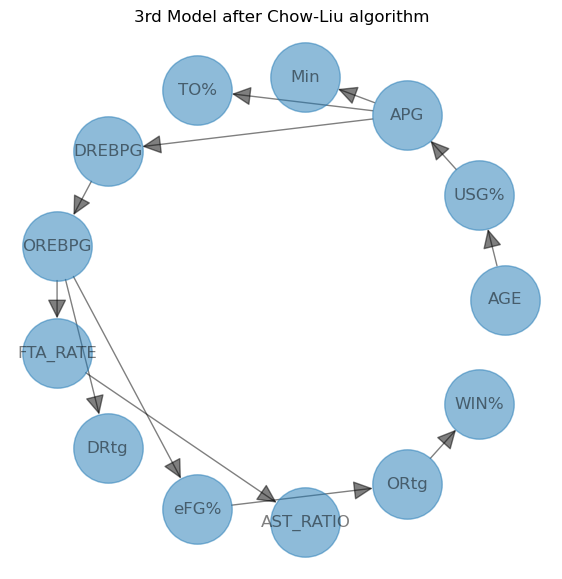

In [426]:
# learn graph structure
est = TreeSearch(df_data, root_node="AGE")
dag = est.estimate(estimator_type="chow-liu")

# Create and fit the new network
best_est_model[2]['model']=BayesianNetwork(dag)
best_est_model[2]['model'].fit(
                    discretized_df,
                    n_jobs=6)
model_checker(best_est_model[2]['model'])

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
nx.draw_circular(
    dag,
    with_labels=True,
    arrowsize=30,
    node_size=2500,
    alpha=0.5
)
ax.set_title('3rd Model after Chow-Liu algorithm')

### TEST SET

In [427]:
df1 = pd.read_csv('datasets/test/NBA_Stats_202223_All_Stats_NBA_Player_Props_Tool.csv')

df1 = df1.drop('RANK', axis=1)
df1['NAME'] = normalizer(df1)
df1.head()

,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,FT%,...,APG,SPG,BPG,TPG,P+R,P+A,P+R+A,VI,ORtg,DRtg
0,joelembiid,Phi,C-F,29.1,66,34.6,37.0,14.5,771,0.857,...,4.2,1.0,1.7,3.4,43.2,37.2,47.4,13.0,124.4,104.1
1,lukadoncic,Dal,F-G,24.1,66,36.2,37.7,14.0,694,0.742,...,8.0,1.4,0.5,3.6,41.0,40.4,49.0,14.4,120.0,109.2
2,damianlillard,Por,G,32.7,58,36.3,33.8,13.7,558,0.914,...,7.3,0.9,0.3,3.3,36.9,39.5,44.3,11.5,126.4,117.6
3,shaigilgeousalexander,Okc,G-F,24.7,68,35.5,32.8,12.2,739,0.905,...,5.5,1.6,1.0,2.8,36.2,36.9,41.7,10.6,124.9,109.8
4,giannisantetokounmpo,Mil,F,28.3,63,32.1,38.8,16.2,772,0.645,...,5.7,0.8,0.8,3.9,42.9,36.8,48.6,15.9,116.8,100.6


In [428]:
print('the dataset columns are: ',df1.columns.values)

the dataset columns are:  ['NAME' 'TEAM' 'POS' 'AGE' 'GP' 'MPG' 'USG%' 'TO%' 'FTA' 'FT%' '2PA' '2P%'
 '3PA' '3P%' 'eFG%' 'TS%' 'PPG' 'RPG' 'APG' 'SPG' 'BPG' 'TPG' 'P+R' 'P+A'
 'P+R+A' 'VI' 'ORtg' 'DRtg']


We chose to merge this dataset with another one because we were missing some crucial variable (wins,minutes played, field goal attempts, assists, turnovers offensive rebounds, defensive rebounds)

In [429]:
df2 = pd.read_csv('datasets/test/2023_nba_player_stats.csv')

df2.rename(columns={'Player':'NAME'},inplace=True)
df2 = df2[['NAME', 'W', 'Min', 'FGA', 'AST', 'TOV', 'OREB', 'DREB']].copy()
df2['NAME'] = normalizer(df2)

df2.head()


,NAME,W,Min,FGA,AST,TOV,OREB,DREB
0,jaysontatum,52.0,2732.2,1559.0,342.0,213.0,78.0,571.0
1,joelembiid,43.0,2284.1,1328.0,274.0,226.0,113.0,557.0
2,lukadoncic,33.0,2390.5,1449.0,529.0,236.0,54.0,515.0
3,shaigilgeousalexander,33.0,2416.0,1381.0,371.0,192.0,59.0,270.0
4,giannisantetokounmpo,47.0,2023.6,1278.0,359.0,246.0,137.0,605.0


In [430]:
df_test = pd.merge(df1, df2, on='NAME')#.reset_index()

We chose to analyze the stats of players who have played at least 41 games last season, which is half the amount of game of the Regular Season

In [431]:
df_test = df_test[df_test['GP'] >= GP_threshold]

if df_checker(df_test):
    df_test.dropna(axis=0, inplace=True, ignore_index=True)
df_test = df_finalizer(df_test)
df_test.head()

The dataset does not contains missing values


,NAME,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
0,joelembiid,29.1,4.2,35.575202,0.573,0.580572,104.1,8.439394,2284.1,14.5,1.712121,124.4,37.0,0.651515
1,lukadoncic,24.1,8.0,27.546679,0.560,0.478951,109.2,7.803030,2390.5,14.0,0.818182,120.0,37.7,0.500000
2,shaigilgeousalexander,24.7,5.5,32.567117,0.531,0.535119,109.8,3.970588,2416.0,12.2,0.867647,124.9,32.8,0.485294
3,giannisantetokounmpo,28.3,5.7,34.732845,0.571,0.604069,100.6,9.603175,2023.6,16.2,2.174603,116.8,38.8,0.746032
4,jaysontatum,25.1,4.6,26.050392,0.543,0.398974,106.7,7.716216,2732.2,12.0,1.054054,118.6,32.7,0.702703


In [432]:
df_test.describe()

,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,26.087179,2.713846,16.757678,0.556174,0.260530,109.190256,3.675284,1875.620513,13.025641,1.137869,116.962051,19.543590,0.517958
std,3.746970,1.950063,7.550859,0.052515,0.126228,4.264956,1.812302,530.359598,3.625932,0.780494,8.739400,5.882439,0.120375
min,19.400000,0.400000,2.940188,0.426000,0.042929,93.200000,0.578125,689.000000,5.600000,0.200000,97.400000,6.500000,0.193548
25%,23.250000,1.200000,11.341493,0.522000,0.160219,106.200000,2.367629,1475.850000,10.500000,0.563859,111.400000,15.200000,0.462113
50%,25.400000,2.100000,15.565717,0.555000,0.240678,109.200000,3.237500,1956.600000,12.700000,0.896104,116.200000,18.200000,0.523077
75%,28.700000,3.700000,21.509048,0.583000,0.333333,111.450000,4.422277,2288.150000,14.900000,1.572152,121.700000,23.050000,0.598838
max,37.900000,10.200000,37.585673,0.732000,0.625000,119.300000,9.603175,2841.500000,30.100000,3.969231,148.700000,38.800000,0.746269


now we need to discretize the testset

In [433]:
discretized_test_df= discretizer(df_test, n_bins=bins)
discretized_test_df.head()

,NAME,AGE,APG,AST_RATIO,eFG%,FTA_RATE,DRtg,DREBPG,Min,TO%,OREBPG,ORtg,USG%,WIN%
0,joelembiid,2,1,3,1,3,1,3,2,1,1,2,3,3
1,lukadoncic,1,3,2,1,2,2,3,3,1,0,1,3,2
2,shaigilgeousalexander,1,2,3,1,3,2,1,3,1,0,2,3,2
3,giannisantetokounmpo,1,2,3,1,3,1,3,2,1,2,1,3,3
4,jaysontatum,1,1,2,1,2,2,3,3,1,0,1,3,3


array([[<Axes: title={'center': 'AGE'}>, <Axes: title={'center': 'APG'}>,
        <Axes: title={'center': 'AST_RATIO'}>,
        <Axes: title={'center': 'eFG%'}>],
       [<Axes: title={'center': 'FTA_RATE'}>,
        <Axes: title={'center': 'DRtg'}>,
        <Axes: title={'center': 'DREBPG'}>,
        <Axes: title={'center': 'Min'}>],
       [<Axes: title={'center': 'TO%'}>,
        <Axes: title={'center': 'OREBPG'}>,
        <Axes: title={'center': 'ORtg'}>,
        <Axes: title={'center': 'USG%'}>],
       [<Axes: title={'center': 'WIN%'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

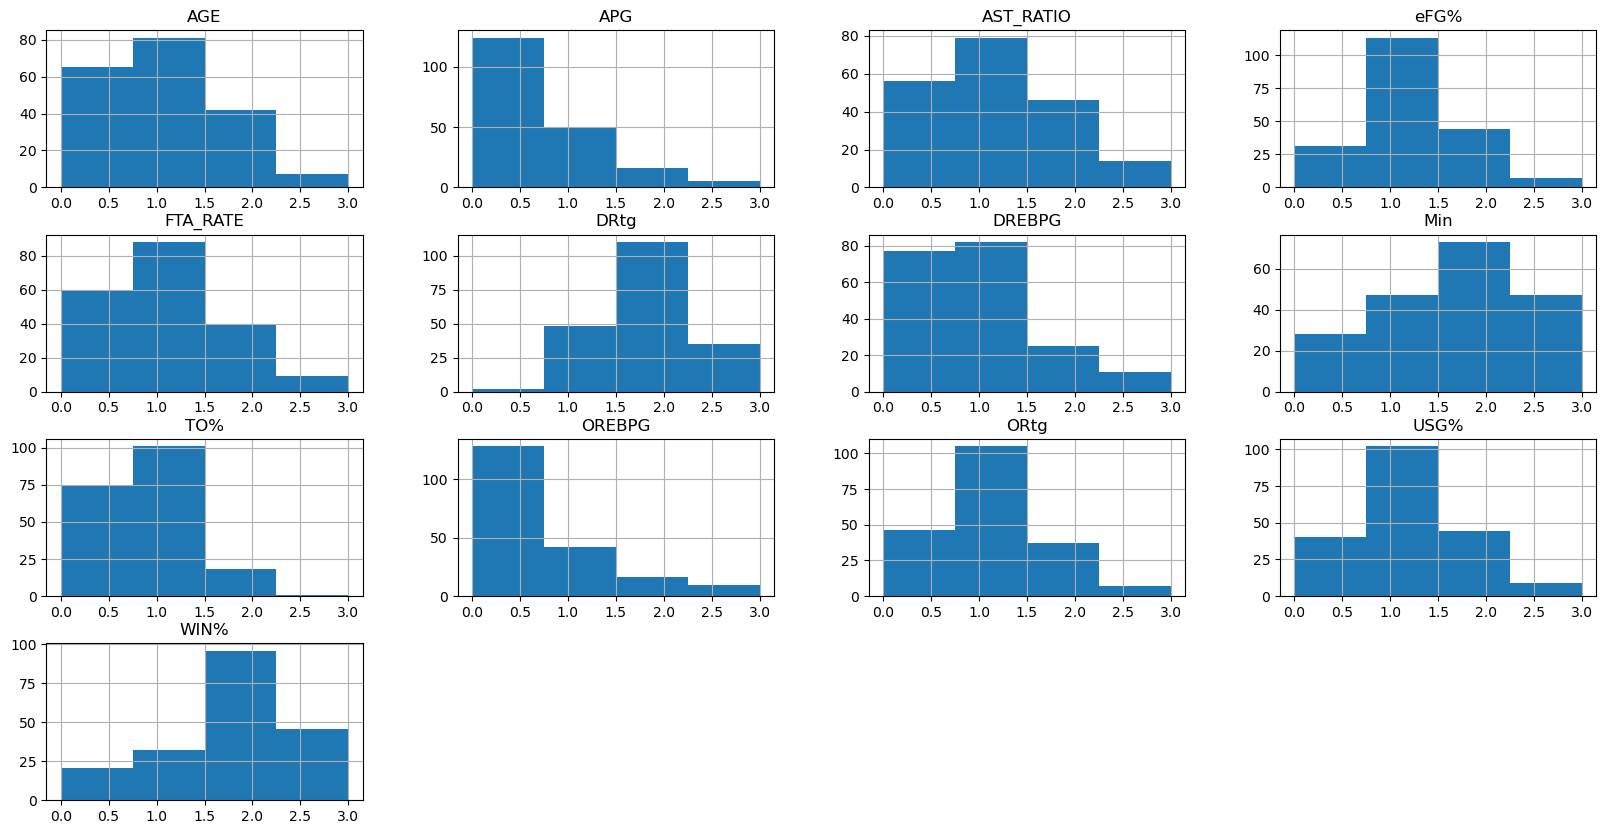

In [434]:
discretized_test_df.hist(bins=bins, figsize=(20,10))

As we can see there are several differences in distributions on the testset in respect to the one obtained on the 'training'.

# Test the performance of the various models
firstly we want to asses the performance of the first model on the test set

In [435]:
test_results={'estimated':[]}
for i in range(discretized_test_df.shape[0]):
    result = nb_inference.query(
            variables=['WIN%'],
            evidence=discretized_test_df
                .drop('WIN%', axis=1)
                .drop('NAME', axis=1)
                .iloc[i]
                .to_dict(),
            show_progress=False,
        )
    test_results['estimated'].append(np.argmax(result.values))
    

evaluate the MAE

In [436]:
test_mae = mean_absolute_error(discretized_test_df['WIN%'].values,test_results['estimated'])
print(test_mae)

0.676923076923077


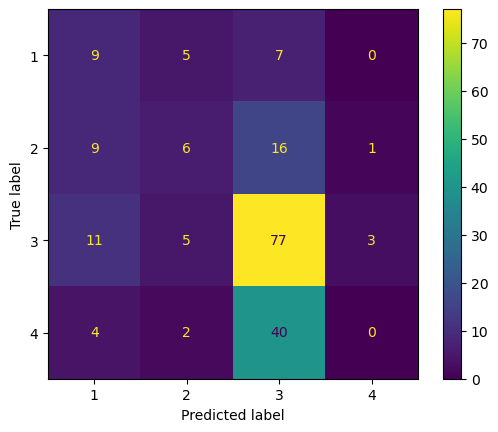

In [437]:
cm = confusion_matrix(discretized_test_df['WIN%'].values,test_results['estimated'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=range(1,bins+1))
disp.plot()
plt.show()

do the same operation on the estimated models

0.6358974358974359


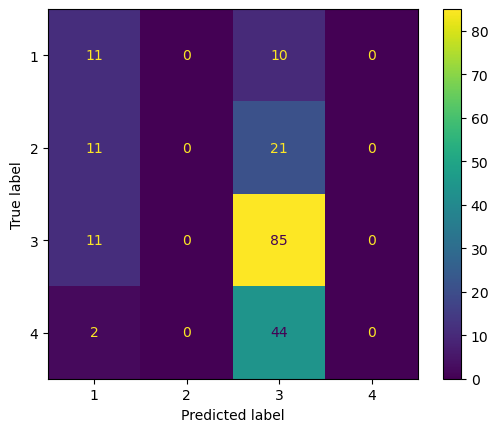

0.7589743589743589


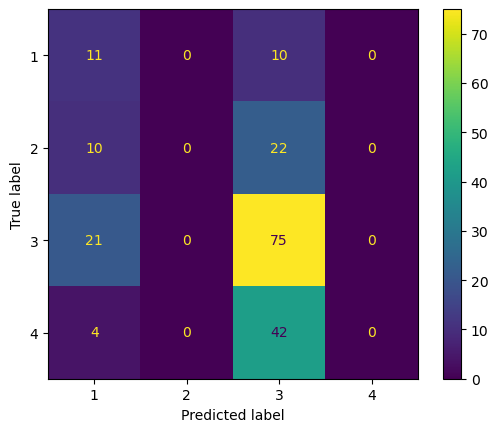

In [438]:
interesting_models = [1,2]
# best_est_model[i]['model']
for i in interesting_models:
    test_results={'estimated':[]}
    nb_inference = VariableElimination(best_est_model[i]['model'])

    for i in range(discretized_test_df.shape[0]):
        result = nb_inference.query(
                variables=['WIN%'],
                evidence=discretized_test_df
                    .drop('WIN%', axis=1)
                    .drop('NAME', axis=1)
                    .iloc[i]
                    .to_dict(),
                show_progress=False,
            )
        test_results['estimated'].append(np.argmax(result.values))
    test_mae = mean_absolute_error(discretized_test_df['WIN%'].values,test_results['estimated'])
    print(test_mae)
    cm = confusion_matrix(discretized_test_df['WIN%'].values,test_results['estimated'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=range(1,bins+1))
    disp.plot()
    plt.show()
    

Even if the first model obtain worst result than the first of the estimated (Infact lower MAE is better, it is a measure of the error), our model is able to capture and give results in the whole range of the binning, thus it behave better.
For that reason from now on we focus only on the first model wich is the best.
With better and bigger dataset we should be able to obtain even better results.

# Queries

Can we affirm that there is a specific age range where a player reaches the peak performance?
We query the offensive and defensive rating given the age to prove that.

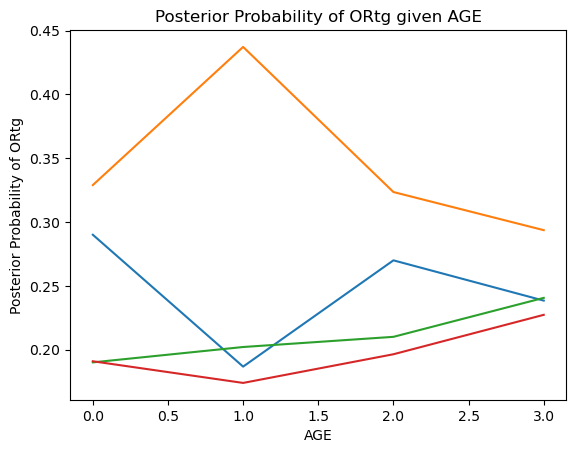

In [439]:
from pgmpy.inference import VariableElimination
 
infer = VariableElimination(custom_model)
# posterior_p = infer.query(['ORtg'], evidence={'AGE': 3})
# print(posterior_p)

import matplotlib.pyplot as plt

age_range = range(0, bins)
posterior_probabilities = []

for age in age_range:
    posterior_p = infer.query(['ORtg'], evidence={'AGE': age})
    posterior_probabilities.append(posterior_p.values)

plt.plot(age_range, posterior_probabilities)
plt.xlabel('AGE')
plt.ylabel('Posterior Probability of ORtg')
plt.title('Posterior Probability of ORtg given AGE')
plt.show()




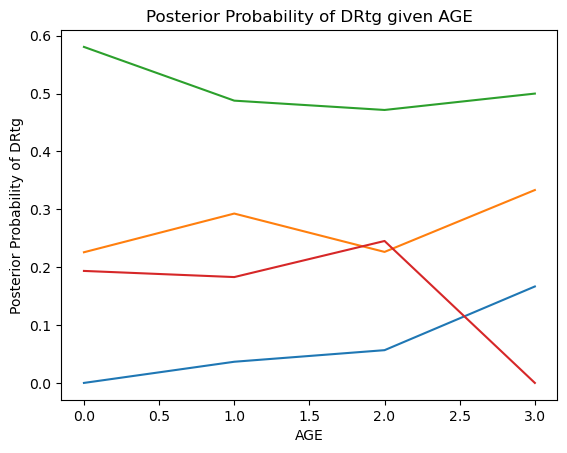

In [440]:
from pgmpy.inference import VariableElimination
 
infer = VariableElimination(custom_model)
# posterior_p = infer.query(['DRtg'], evidence={'AGE': 3})
# print(posterior_p)

import matplotlib.pyplot as plt

age_range = range(0, bins)
posterior_probabilities = []

for age in age_range:
    posterior_p = infer.query(['DRtg'], evidence={'AGE': age})
    posterior_probabilities.append(posterior_p.values)

plt.plot(age_range, posterior_probabilities)
plt.xlabel('AGE')
plt.ylabel('Posterior Probability of DRtg')
plt.title('Posterior Probability of DRtg given AGE')
plt.show()

Is the winning percentage influenced by the offensive and defensive rating?

+---------+-------------+
| WIN%    |   phi(WIN%) |
+=========+=============+
| WIN%(0) |      0.6830 |
+---------+-------------+
| WIN%(1) |      0.1880 |
+---------+-------------+
| WIN%(2) |      0.1289 |
+---------+-------------+
| WIN%(3) |      0.0000 |
+---------+-------------+


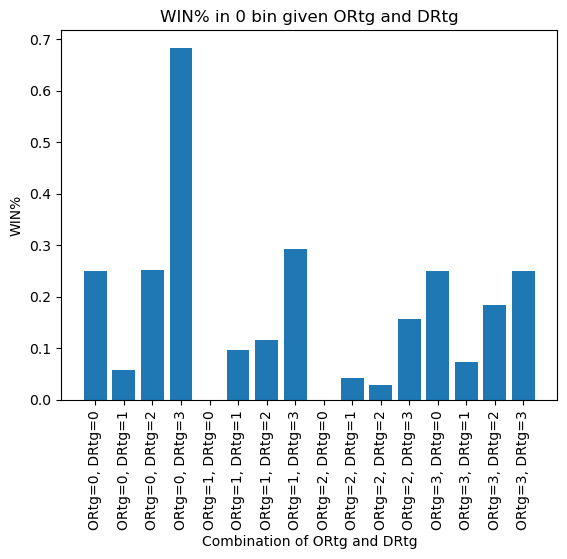

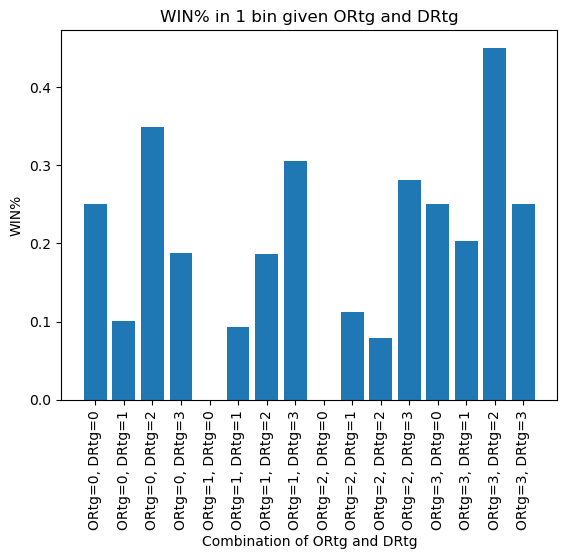

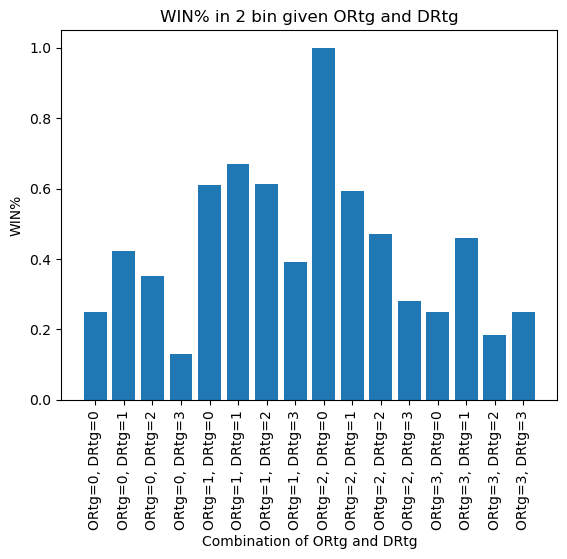

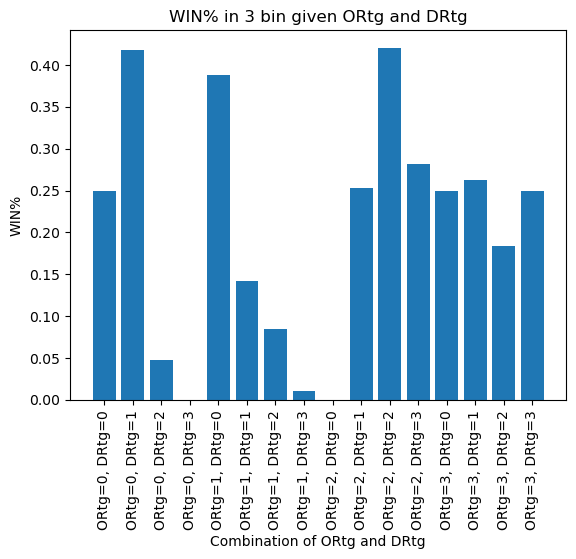

In [448]:
infer = VariableElimination(custom_model)
posterior_p = infer.query(['WIN%'], evidence={'ORtg': 0, 'DRtg': 3})
print(posterior_p)

infer = VariableElimination(custom_model)

# Query all values of ORtg and DRtg
ortg_values = range(0, bins)
drtg_values = range(0, bins)


for i in range(0, bins):
    win_percentages = []
    for ortg in ortg_values:
        for drtg in drtg_values:
            posterior_p = infer.query(['WIN%'], evidence={'ORtg': ortg, 'DRtg': drtg})
            win_percentages.append(posterior_p.values[i])

    # Plot the bar plot
    fig, ax = plt.subplots()
    x = range(len(win_percentages))
    ax.bar(x, win_percentages)
    ax.set_xlabel('Combination of ORtg and DRtg')
    ax.set_ylabel('WIN%')
    ax.set_title('WIN% in ' + str(i) + ' bin given ORtg and DRtg')
    ax.set_xticks(x)
    ax.set_xticklabels([f'ORtg={ortg}, DRtg={drtg}' for ortg in ortg_values for drtg in drtg_values], rotation=90)
    plt.show()



Is it true that as a player gets older the usage percentage decreases?

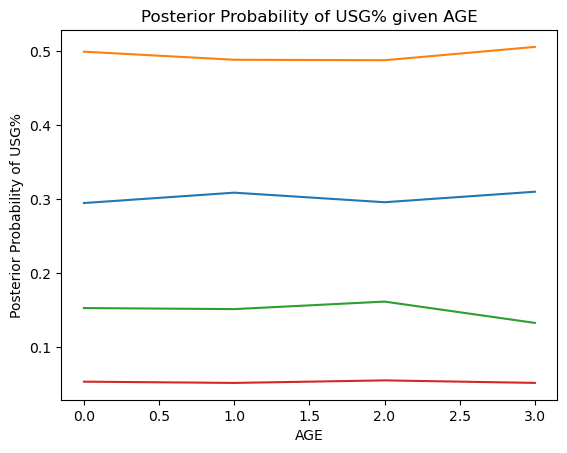

In [442]:
from pgmpy.inference import VariableElimination
 
infer = VariableElimination(custom_model)
# posterior_p = infer.query(['USG%'], evidence={'AGE': 0})
# print(posterior_p)

age_range = range(0, bins)
posterior_probabilities = []

for age in age_range:
    posterior_p = infer.query(['USG%'], evidence={'AGE': age})
    posterior_probabilities.append(posterior_p.values)

plt.plot(age_range, posterior_probabilities)
plt.xlabel('AGE')
plt.ylabel('Posterior Probability of USG%')
plt.title('Posterior Probability of USG% given AGE')
plt.show()

Can we prove that a player that makes a lot of assist tends to lose the ball more?

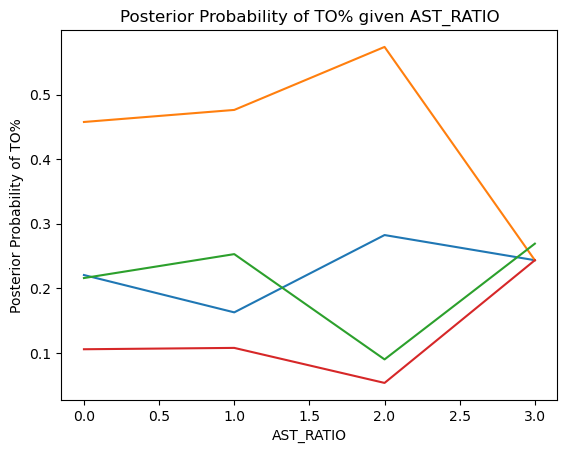

In [443]:
infer = VariableElimination(custom_model)
# posterior_p = infer.query(['TO%'], evidence={'AST_RATIO': 3})
# print(posterior_p)

ast_ratio_range = range(0, bins)
posterior_probabilities = []

for ast_ratio in ast_ratio_range:
    posterior_p = infer.query(['TO%'], evidence={'AST_RATIO': ast_ratio})
    posterior_probabilities.append(posterior_p.values)

plt.plot(age_range, posterior_probabilities)
plt.xlabel('AST_RATIO')
plt.ylabel('Posterior Probability of TO%')
plt.title('Posterior Probability of TO% given AST_RATIO')
plt.show()